# cs7324 Lab 6 - Sequential Networks

#### Chip Henderson - 48996654 


## Preparation

In this lab, I'll be using a collection of Tweets related to the coronavirus pandemic. My intent is to use Convolutional Neural Network and Transformer models to analyze sentiment.

Source: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

### Data Import and Tokenization

My dataset is already split into training and testing categories. Since I will need to split out my y values as well, and I'd like to see some distributions before agreeing with the split somoeone else came up with, I'm going to combine the two.

In [22]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import sequence

# I'm using a latin enoding because there are some special characters
df_train = pd.read_csv(r'C:\Users\Chip\source\repos\cs7324_code\Data_Sources\Coronavirus_tweets\Corona_NLP_train.csv',encoding='iso-8859-1')
df_test = pd.read_csv(r'C:\Users\Chip\source\repos\cs7324_code\Data_Sources\Coronavirus_tweets\Corona_NLP_test.csv',encoding='iso-8859-1')

df_covid = pd.concat([df_train, df_test])

df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


#### Tokenization

At a glance of the examples above. There are some characters that I'm not sure I want to include in my embeddings. Some are stop words like "a," "the," "is," "are." Others are @tags that I don't believe will help my sentiment predictions. When I tokenize these Tweets I'm going to remove the stop words and will examine some differences in leaving the @tags in or removing them. Idea behind this is that I further reduce dataset complexity by removing these words that don't add value to prediction.

The Keras tokenizer doesn't support removal of stop-words. So I'm going to be using NLTK to do the initial tokenization.

In [23]:
%%time
# Source: Modified from in-class lecture notebook 13a
# Source: Previous code written for cs7320 NLP

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

# Function to tokenize and remove stopwords
def tokenize_and_remove_stopwords(tweet):
    tokens = word_tokenize(tweet)
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Apply tokenization and stop word removal to the 'OriginalTweet' column
df_covid['OriginalTweet'] = df_covid['OriginalTweet'].apply(tokenize_and_remove_stopwords)

print(df_covid)




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


      UserName  ScreenName             Location     TweetAt  \
0         3799       48751               London  16-03-2020   
1         3800       48752                   UK  16-03-2020   
2         3801       48753            Vagabonds  16-03-2020   
3         3802       48754                  NaN  16-03-2020   
4         3803       48755                  NaN  16-03-2020   
...        ...         ...                  ...         ...   
3793      3794       48746            Israel ??  16-03-2020   
3794      3795       48747       Farmington, NM  16-03-2020   
3795      3796       48748        Haverford, PA  16-03-2020   
3796      3797       48749                  NaN  16-03-2020   
3797      3798       48750  Arlington, Virginia  16-03-2020   

                                          OriginalTweet           Sentiment  
0     @ MeNyrbie @ Phil_Gahan @ Chrisitv https : //t...             Neutral  
1     advice Talk neighbours family exchange phone n...            Positive  
2     Cor

#### Dimensionality Reduction

Because of the memory footprint and compute times for some of these networks, I'm going to make my dataset as simple as possible. Also, I'm focused on performing a many-to-one analysis. Therefore, I'll be dropping everything except for the Original Tweet and Sentiment columns. 

In [2]:
features_to_keep = ['OriginalTweet', 'Sentiment']
features_to_drop = [feature for feature in df_covid.columns if feature not in features_to_keep]

# Drop features I won't be using for this lab
df_covid_reduced = df_covid.drop(features_to_drop,axis=1)

# Determine number of instances 
df_covid_reduced.value_counts

<bound method DataFrame.value_counts of                                           OriginalTweet           Sentiment
0     @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral
1     advice Talk to your neighbours family to excha...            Positive
2     Coronavirus Australia: Woolworths to give elde...            Positive
3     My food stock is not the only one which is emp...            Positive
4     Me, ready to go at supermarket during the #COV...  Extremely Negative
...                                                 ...                 ...
3793  Meanwhile In A Supermarket in Israel -- People...            Positive
3794  Did you panic buy a lot of non-perishable item...            Negative
3795  Asst Prof of Economics @cconces was on @NBCPhi...             Neutral
3796  Gov need to do somethings instead of biar je r...  Extremely Negative
3797  I and @ForestandPaper members are committed to...  Extremely Positive

[44955 rows x 2 columns]>

From the example above I see there are a few different sentiments as target values. I'll look at these in more detail because I may want to just make this as few classes as possible (positive/negative/Netral) instead of trying to predict the degree to which something is positive or negative. 

Predicting how positive or how negative a Tweet is would be diving more deeply into sentiment analysis as opposed to focusing on creating the neural networks to train on this data, so I'm considering it beyond the scope of this lab.

In [3]:
# How many unique target values are there?
print(df_covid_reduced.Sentiment.unique())

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']


In [4]:
# Take 'Extremely Positive' and 'Extremely Negative' and make them align with 'Positive' or 'Negative'
df_covid_reduced.loc[df_covid_reduced['Sentiment'] == 'Extremely Negative'] = 'Negative'
df_covid_reduced.loc[df_covid_reduced['Sentiment'] == 'Extremely Positive'] = 'Positive'

print(df_covid_reduced.Sentiment.unique())

['Neutral' 'Positive' 'Negative']


#### Class Distribution

Let's see how the distribution of positive, negative, and neutral appear in the data. The purpose of this is to determine how imbalanced my classes might be. Since the subject matter is Covid-19, I'm going to guess my negatives are going to outweigh things. But we'll see below.

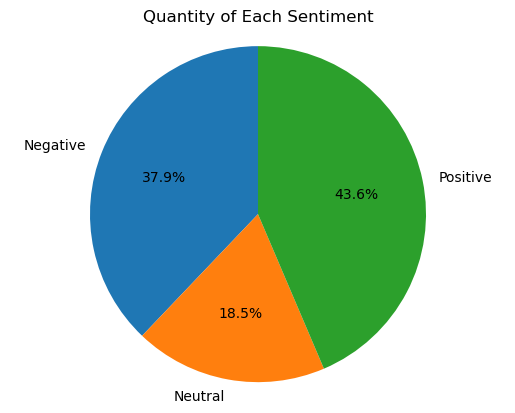

Sentiment
Positive     19592
Negative     17031
Neutral       8332
Name: count, dtype: int64

In [5]:
# Source: Chat-GPT for correcting some pie chart artifacts that were overlapping
# This was done after selecting the pie chart as my method of presenting the data
import matplotlib
import matplotlib.pyplot as plt

sentiments = df_covid_reduced.groupby(['Sentiment'])
pie_data = sentiments.size() # Chat-GPT change

# Chat-GPT recommended adding a startangle and using pie_data instead of 
# using the column name which made the chart too cluttered.
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', labeldistance=1.1, startangle=90)

plt.title("Quantity of Each Sentiment")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Get the exact count of each value to provide further information
df_covid_reduced.value_counts(['Sentiment'])

These results didn't align with my expectations, but that's why I'm checking them. I'm usng a pie chart here because its a simple straight forward method for communicating class balance visually. This will help guide decisions on data splitting.

#### Data Split

I'm surprised that we have so many positive tweets but they're relatively close to negative quantities. Neutrals are the least represented category. Based on the quantities in each classification, I believe I'm going to want to stratify this data to ensure I have an equal representation in my training and test data. I'll do that below and check the results.

In [6]:
from sklearn.model_selection import train_test_split
from pprint import pprint

# Get basic X and y datasets
X = df_covid_reduced.OriginalTweet.values
y = df_covid_reduced.Sentiment.values

# Split my data in to training and test 80/20
df_train, df_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, stratify=y)

# Let's double check the distributions to make sure that stratify has done what I wanted
# Source:https://stackoverflow.com/questions/10741346/frequency-counts-for-unique-values-in-a-numpy-array

# Get the counts of unique values in training data
unique_train_classes, counts = np.unique(y_train, return_counts=True)

# Calculate the total number of elements in the array
total_elements = len(y_train)

# Calculate the percentage of total for each count
percentages = (counts / total_elements) * 100

print(np.asarray((unique_train_classes, counts, percentages.round(0))).T, '\n')

# Same as above for test for comparison
unique_test_classes, counts = np.unique(y_test, return_counts=True)
total_elements = len(y_test)
percentages = (counts / total_elements) * 100

print(np.asarray((unique_test_classes, counts, percentages.round(0))).T)



[['Negative' 13625 38.0]
 ['Neutral' 6665 19.0]
 ['Positive' 15674 44.0]] 

[['Negative' 3406 38.0]
 ['Neutral' 1667 19.0]
 ['Positive' 3918 44.0]]


Everything worked as expected. My training data and test data now mirror eachother from a class representation perspective.

Let's see how long my longest tweet is. Depending on when this data was collected the max length could vary.

In [7]:
print(max(df_train, key=len))
print(f"The longest tweet from the training data is {len(max(df_train, key=len))}")
print(f"The longest tweet from the test data is {len(max(df_test))}")

#Oil futures in NY jumped 11% to $22.54/barrel. More below.

Noon prices:
#SPX500Â2421.4
#NAS100Â7288.3
#WTIÂ22.41
#GOLDÂ1485.89
#SILVERÂ12.165

Practise trading oil on a free demo: https://t.co/x9ZztKCodE

#coronavirus #COVID19 #COVID2019AU #DonaldTrump #CoronaVirusOutbreak https://t.co/rmjLqCuIFB https://t.co/jcb2OAumGx
The longest tweet from the training data is 350
The longest tweet from the test data is 221


So, at most I'll have a 350 token tweet before I remove some of the elements I spoke about above.

In [ ]:
from tensorflow import keras
# from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_TWEET_LEN = 350 # maximum and minimum number of words

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(bunch.target)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))